# PCA of NOAA-GridSat-B1

In this notebook, we will perform Principle Component Analysis on the NOAA-GridSat-B1 data in 1998 \~ 2018 (21 years). From the previous notebook we found that data quality of NOAA-GridSat-B1 had significant improvement after 2013 (less peaks on min/max values, i.e., less outliers), we will also perform PCA on 2013~2018 data to see if there are differences.


## Prototyping

In [1]:
# I/O and utilities
import numpy as np
import pandas as pd
import os, argparse, logging
from sklearn.decomposition import PCA, IncrementalPCA
import joblib

# Utility functions
def list_noaagridsatb1_files(dir, suffix='.v02r01.nc', to_remove=['GRIDSAT-B1.','.v02r01.nc']):
    ''' To scan through the sapecified dir and get the corresponding file with suffix. '''
    import os
    import pandas as pd
    xfiles = []
    for root, dirs, files in os.walk(dir):  # Loop through the directory
        for fn in files:
            if fn.endswith(suffix):         # Filter files with suffix
                timestamp = fn
                for s in to_remove:         # Removing prefix and suffix to get time-stamp
                    timestamp = timestamp.replace(s,'')
                xfiles.append({'timestamp':timestamp, 'xuri':os.path.join(root, fn)})
    return(pd.DataFrame(xfiles).sort_values('timestamp').reset_index(drop=True))

# Binary reader
def read_noaagridsatb1(furi, var='irwin_cdr', scale=0.01, offset=200, remove_na=True, crop_east_asia=True):
    ''' The method reads in a NOAA-GridSta-B1 image in netCDF4 format (.nc file). 
        The brightness temperature data was stored in int16 as 'irwin_cdr', with 
        a scal factor of 0.01 and offset of 200. The missing values is flagged as -31999.
        More details of the data is described in https://developers.google.com/earth-engine/datasets/catalog/NOAA_CDR_GRIDSAT-B1_V2.
        Since our analysis focuss on East Asia (0-60'N, 100-160'E), we used an 
        option to crop the data to this region (index: lat:1000~1858, lon:4000~4858).
        The output is a 2-d numpy array of float32 with shape (858, 858).
    '''
    import numpy as np
    import netCDF4 as nc
    # Read in data
    data = nc.Dataset(furi)
    cdr = np.array(data.variables['irwin_cdr'])*scale+offset
    # Remove missing value
    if remove_na:
        cdr[cdr<0] = offset
    # Crop domain to East-Asia (0-60'N, 100-160'E)
    if crop_east_asia:
        return(cdr[0, 1000:1858, 4000:4858])
    else:
        return(cdr[0,:,:])

def read_multiple_noaagridsatb1(flist, flatten=False):
    ''' This method reads in a list of NOAA-GridSat-B1 images and returns a numpy array. '''
    import numpy as np
    data = []
    for f in flist:
        tmp = read_noaagridsatb1(f)
        if flatten:
            tmp = tmp.flatten()
        data.append(tmp)
    return(np.array(data))


# Incremental PCA
def fit_ipca_partial(finfo, n_component=20, batch_size=128):
    ''' Initial and fit a PCA model with incremental PCA. '''
    ipca = IncrementalPCA(n_components=n_component, batch_size=batch_size)
    # Loop through finfo
    nSample = len(finfo)
    batch_start = 0
    batch_end = batch_size
    batch_count = 0
    while batch_start < nSample:
        # Check bound
        limit = min(batch_end, nSample)         # Check for the final batch
        if n_component>(nSample-batch_end):     # Merge the final batch if it's too small
            print('The final batch is too small, merge it to the previous batch.')
            limit = nSample
        # Read batch data
        data = read_multiple_noaagridsatb1(finfo['xuri'].iloc[batch_start:limit], flatten=True)
        print(data.shape)
        # increment
        batch_start += limit   
        batch_end += batch_size
        batch_count += 1
        # Partial fit with batch data
        ipca.partial_fit(data)
    #
    return(ipca)

In [2]:
files = list_noaagridsatb1_files('../../data/noaa/')
ipca = fit_ipca_partial(files, n_component=4, batch_size=5)

The final batch is too small, merge it to the previous batch.
(8, 736164)


In [3]:
ev = ipca.explained_variance_
evr = ipca.explained_variance_ratio_
com = np.transpose(ipca.components_)

print(ev)
print(evr)
print(com.shape)

[29755648. 18266374. 11480846.  8797922.]
[0.34650448 0.2127119  0.13369444 0.10245179]
(736164, 4)


## PCA with Mass Dataset

We developed a script performing Incremental-PCA in `[REPO_ROOT]/utils/ipca_noaagridsatb1.py`. The usage is:

```[REPO_ROOT]/workspace/> python ../utils/ipca_noaagridsatb1.py -i [DATA_DIR] -o [OUPUT_PREFIX] -n [NUMBER_OF_PC] -b [BATCH_SIZE] -l [LOG_FILE]```

Upon the completion of the computation (\~12hr for 1998\~2018 data), we will receive a summary of explained variance ([OUTPUT_PREFIX].exp_var.csv) and a PCA model ([`sklearn.decomposition.IncrementalPCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html)) stored with [`joblib`](https://joblib.readthedocs.io/en/latest/).

### 1998 - 2018

In [1]:
import numpy as np
import pandas as pd
import os, argparse, logging
from sklearn.decomposition import PCA, IncrementalPCA
import joblib, csv

ipca = joblib.load('../../workspace/ipca_full.pca.mod')


C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator IncrementalPCA from version 0.20.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### Ratio of explained variances

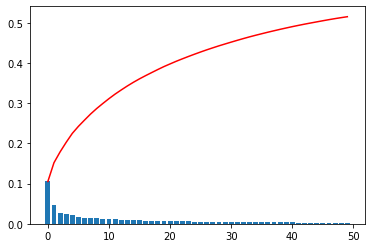

In [2]:
ev = ipca.explained_variance_
evr = ipca.explained_variance_ratio_

%matplotlib inline
import matplotlib.pyplot as plt

plt.bar(range(50), evr)
plt.plot(np.cumsum(evr), 'r-')
plt.show()

(50, 736164)


C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]


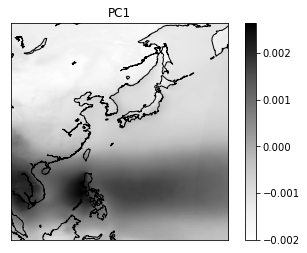

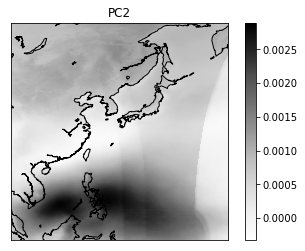

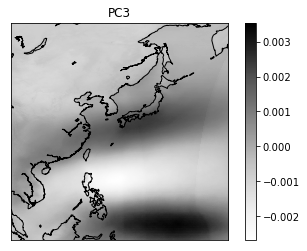

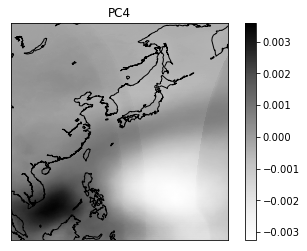

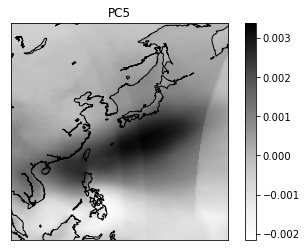

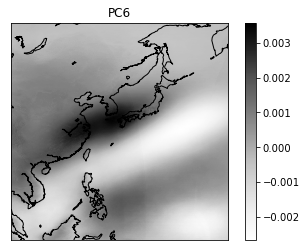

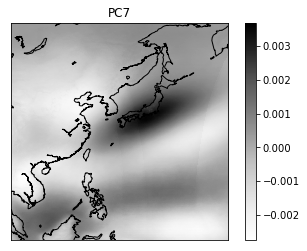

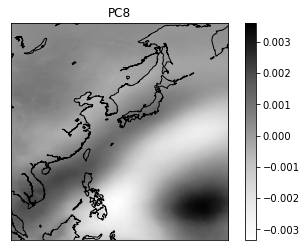

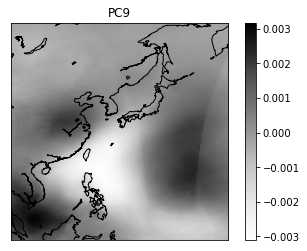

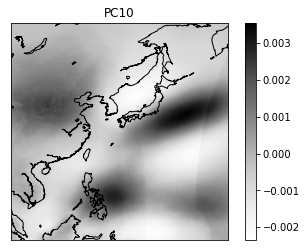

In [3]:
from mpl_toolkits.basemap import Basemap

lat0 = 0.0
lat1 = 60.059998
lon0 = 100.0
lon1 = 160.06

pcs = ipca.components_
print(pcs.shape)

for i in range(10):
    pc = pcs[i,:].reshape(858,858)
    m = Basemap(llcrnrlon=lon0, urcrnrlon=lon1, llcrnrlat=lat0, urcrnrlat=lat1, resolution='l')
    m.drawcoastlines()
    m.imshow(pc, alpha=0.99, cmap='Greys')
    plt.title('PC'+str(i+1))
    plt.colorbar()
    plt.show()



### 2013 - 2018

As mentioned in the beginning, the data quality after 2013 seemed more stable from earlier analysis, hence we perform the same PCA with the smaller subset to see if the results are different.

C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator IncrementalPCA from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


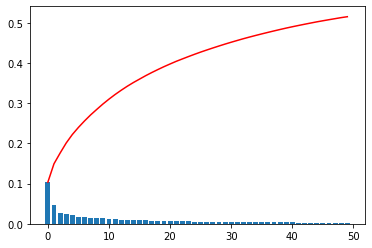

In [5]:
import numpy as np
import pandas as pd
import os, argparse, logging
from sklearn.decomposition import PCA, IncrementalPCA
import joblib, csv

ipca = joblib.load('../../workspace/ipca_13.pca.mod')

ev = ipca.explained_variance_
evr = ipca.explained_variance_ratio_

%matplotlib inline
import matplotlib.pyplot as plt

plt.bar(range(50), evr)
plt.plot(np.cumsum(evr), 'r-')
plt.show()

(50, 736164)


C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]


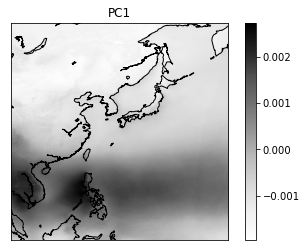

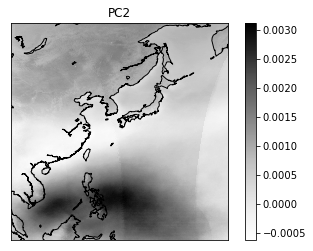

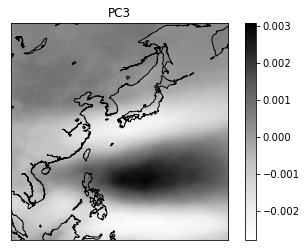

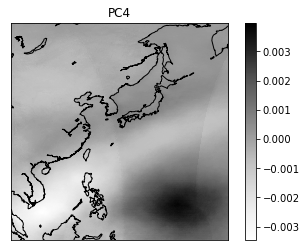

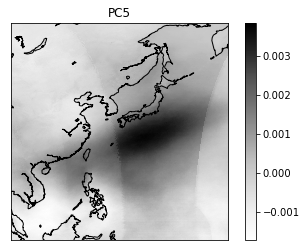

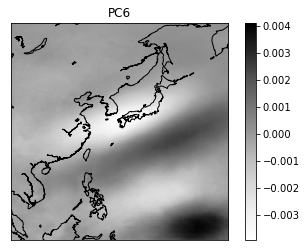

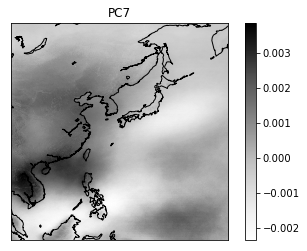

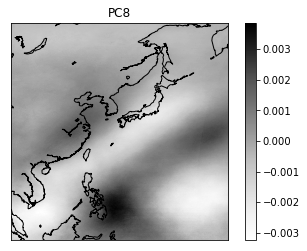

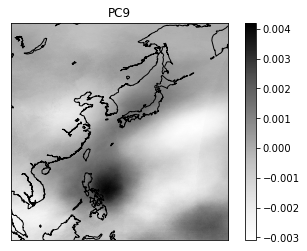

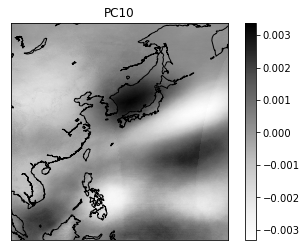

In [6]:
from mpl_toolkits.basemap import Basemap

lat0 = 0.0
lat1 = 60.059998
lon0 = 100.0
lon1 = 160.06

pcs = ipca.components_
print(pcs.shape)

for i in range(10):
    pc = pcs[i,:].reshape(858,858)
    m = Basemap(llcrnrlon=lon0, urcrnrlon=lon1, llcrnrlat=lat0, urcrnrlat=lat1, resolution='l')
    m.drawcoastlines()
    m.imshow(pc, alpha=0.99, cmap='Greys')
    plt.title('PC'+str(i+1))
    plt.colorbar()
    plt.show()

For the first 3 PCs, except the PC3 is in reverse direction, all patterns looks similar. This also suggests that PC is a very stable and robust algorithms.